In [1]:
import os
import json
from pathlib import Path
import typing

import numpy as np
import torch
from transformers import OpenAIGPTLMHeadModel, OpenAIGPTConfig
from muutils.logger import Logger, TimerContext
from muutils.json_serialize import json_serialize, dataclass_serializer_factory
from muutils.tensor_utils import ATensor
from muutils.statcounter import StatCounter
from muutils.misc import shorten_numerical_to_str

from maze_transformer.generation.latticemaze import LatticeMaze
from maze_transformer.generation.generators import LatticeMazeGenerators
from maze_transformer.training.tokenizer import SolvedMaze, SPECIAL_TOKENS
from maze_transformer.training.mazedataset import MazeDatasetConfig, MazeDataset
from maze_transformer.evaluation.plot_maze import plot_multi_paths
from maze_transformer.training.dataset import GPTDatasetConfig
from maze_transformer.training.config import TrainConfig
from maze_transformer.training.training import TRAIN_SAVE_FILES
# from maze_transformer.training.eval_model import plot_predicted_path



Input length of input_ids is 90, but ``max_length`` is set to 5. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


loaded model with 28M parameters
maze tokens: ['<ADJLIST_START>', '(1,0)', '<-->', '(1,1)', ';', '(3,3)', '<-->', '(3,3)', ';', '(0,2)', '<-->', '(0,3)', ';', '(1,3)', '<-->', '(2,3)', ';', '(3,1)', '<-->', '(3,1)', ';', '(1,1)', '<-->', '(2,1)', ';', '(0,0)', '<-->', '(0,1)', ';', '(3,0)', '<-->', '(3,0)', ';', '(1,2)', '<-->', '(1,2)', ';', '(1,2)', '<-->', '(2,2)', ';', '(1,0)', '<-->', '(2,0)', ';', '(0,3)', '<-->', '(1,3)', ';', '(3,3)', '<-->', '(3,3)', ';', '(3,1)', '<-->', '(3,2)', ';', '(0,0)', '<-->', '(1,0)', ';', '(2,1)', '<-->', '(2,2)', ';', '<ADJLIST_END>', '<TARGET_START>', '(3,3)', '<TARGET_END>', '<START_PATH>']
tensor([[ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  0, 13,  6, 14,  7, 24,  6, 24,  7, 11,  6, 12,  7, 16,  6, 20,
          7, 22,  6, 22,  7, 14,  6, 18,  7,  9,  6, 10,  7, 21,  6, 21,  7, 15,
          6, 15,  7, 15,  6, 19,  7, 13,  6, 17,  7, 12,  6, 16,  7, 24,  6, 24,
          7, 22,  6, 23,  7,  9,  6, 1

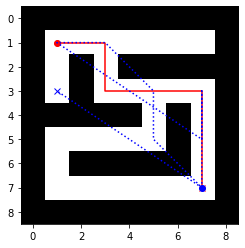

In [14]:

def check_configs_present(folder: Path) -> bool:
	return (
		(folder / TRAIN_SAVE_FILES.data_cfg).exists()
		and (folder / TRAIN_SAVE_FILES.train_cfg).exists()
	)

def load_model_with_configs(model_path: str, data_cfg_class: type, verbose: bool = False) -> tuple[OpenAIGPTLMHeadModel, TrainConfig, GPTDatasetConfig]:
	"""
	Load a model and associated config files from a path.
	"""

	# TODO: make this less fragile
	# load the configs
	# get path to the folder containing the model
	config_folder: Path = Path(model_path).parent
	# check for the filenames, go up a dir if they don't exist
	if not check_configs_present(config_folder):
		config_folder = config_folder.parent
		assert check_configs_present(config_folder), f"Couldn't find configs in directory of or parent directory of {model_path}"

	# load the configs
	with open(config_folder / TRAIN_SAVE_FILES.train_cfg, "r") as f:
		train_cfg_raw: dict = json.load(f)
	
	train_cfg: TrainConfig = TrainConfig.load(train_cfg_raw)
	if verbose:
		print(f"{train_cfg = }")
		print('-'*40)

	model_cfg: OpenAIGPTConfig = OpenAIGPTConfig(**train_cfg._gpt_config_ctor_kwargs)
	if verbose:
		print("model_cfg = ", json_serialize(model_cfg.to_dict(), error_mode = "warn"))
		print('-'*40)

	with open(config_folder / TRAIN_SAVE_FILES.data_cfg, "r") as f:
		data_cfg: GPTDatasetConfig = data_cfg_class.load(json.load(f))

	model: OpenAIGPTLMHeadModel = OpenAIGPTLMHeadModel(model_cfg)
	state_dict: dict = torch.load(model_path)
	# print(state_dict.keys())
	model.load_state_dict(state_dict)
	model.eval()
	print(f"loaded model with {shorten_numerical_to_str(model.num_parameters())} parameters")
	return (model, train_cfg, data_cfg)


def predict_tokens(model: OpenAIGPTLMHeadModel, inputs: ATensor, n_tokens: int = 32, **generate_kwargs):
	"""
	Predict the next token.
	"""
	with torch.no_grad():
		predictions = model.generate(
			inputs, 
			max_length=n_tokens, 
			min_length=n_tokens, 
			**generate_kwargs,
		)
	return predictions

def plot_predicted_path(
		model_path: str,
		grid_n: int = 4,
	):

	model: OpenAIGPTLMHeadModel; train_cfg: TrainConfig; data_cfg: MazeDatasetConfig
	model, train_cfg, data_cfg = load_model_with_configs(model_path, MazeDatasetConfig)

	# generate a maze
	maze: LatticeMaze = LatticeMazeGenerators.gen_dfs((grid_n, grid_n))
	c_start = (0, 0)
	c_end = (grid_n - 1, grid_n - 1)

	# solve the maze explicitly
	path_true = np.array(maze.find_shortest_path(
		c_start = c_start,
		c_end = c_end,
	))

	solved_maze: SolvedMaze = SolvedMaze(
		maze=maze,
		solution=np.array(maze.find_shortest_path(
			c_start=c_start,
			c_end=c_end,
		)),
	)

	# tokenize the maze
	maze_only_tokens: list[str] = solved_maze.as_tokens(data_cfg.node_token_map , solution = False) + [ SPECIAL_TOKENS["start_path"] ]

	print("maze tokens:", maze_only_tokens)

	array_nopad = torch.tensor(
		[ data_cfg.tokenizer_map[t] for t in maze_only_tokens ], 
		dtype=torch.int32,
		device="cpu",
	)

	array = torch.nn.functional.pad(
		array_nopad, 
		(90 - len(array_nopad), 0), 
		value=8,
	)

	# have the model predict some tokens
	predictions = predict_tokens(model, array.unsqueeze(0), 5)

	print(predictions)

	
	# decode the tokens
	predicted_tokens = [ data_cfg.token_arr[t] for t in predictions[0] ]
	
	print(predicted_tokens)

	path_predicted: list[tuple[int,int]] = []

	for token in predicted_tokens[len(maze_only_tokens):]:
		if token.startswith("("):
			# HACK (VERY BAD)
			coord = eval(token)
			print(coord)
			path_predicted.append(coord)

	# plot the maze and both solutions
	# for label, fmt, color, path in paths
	plot_multi_paths(
		maze = maze,
		paths = [
			(path_true, "true", "-", "red"),
			(np.array(path_predicted), "predicted", ":", "blue"),
		],
	)


plot_predicted_path("data/g4-n4K/g4-n4K_tiny-v1_2022-09-10-02-02-12/checkpoints/model.iter_3120.pt", grid_n=4)
